<a href="https://colab.research.google.com/github/cafalchio/EXvivo/blob/main/spike2_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Trying to replicate power calculation from spike2

    
**to do: Find why the power is different**

In [1]:
!pip install neo -q

In [75]:
import neo
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.signal import welch

import gc
gc.enable()
import warnings
warnings.filterwarnings('ignore')

In [78]:
# create a reader
reader = neo.io.Spike2IO(filename='/content/drive/MyDrive/aHuman_data_Mark/210308_000.smr', try_signal_grouping=False)
print(reader)
# read the block
raw_data = reader.read(lazy=False)[0]
for seg in raw_data.segments:
    print("Analyzing segment %d" % seg.index)
    raw_data = np.mean(seg.analogsignals[0], axis=1)
del reader, seg
gc.collect()

Spike2IO: /content/drive/MyDrive/aHuman_data_Mark/210308_000.smr
nb_block: 1
nb_segment:  [1]
signal_streams: [untitled (chans: 1), untitled (chans: 1)]
signal_channels: [untitled, untitled]
spike_channels: [untitled , untitled , untitled , untitled ]
event_channels: [Keyboard]

Analyzing segment 0


12843

In [79]:
def calculate_fft(x, window=1):
    '''Calculates the LFP of the signal in windows n minutes'''
    win = window * fs * 60
    g = int(len(x)/win)
    # print(g)
    fftx = []
    for i in range(g):
        start = i*win
        end = i*win+win
        # print(len(data[start:end])/2500)
        fftx.append(fft(x[start:end], n=2048*4))
        break
    return np.array(fftx)
def plot_nice(data):
    '''Adapted from Raphael Vallat blog
    '''

    fs = 5000
    sns.set(font_scale=1.2)
    # Define sampling frequency and time vector
    time = np.arange(data.size) / fs
    # return time
    # Plot the signal
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    plt.plot(time, data, lw=1.5, color='k')
    plt.locator_params(axis='x', nbins=25)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage')
    plt.xlim([time.min(), time.max()])
    # plt.savefig(f'{slice_name}_treatments_ch0_no_notch.jpg')
    sns.despine()
    plt.show()
    plt.close()
    del time, fig, ax
    gc.collect()

def zoom_in(zoom= [], data=data):
    fs = 5000
    assert type(zoom) == list
    # data = slice1_151015_130152.get_data()[0]
    data = data[zoom[0]*fs:zoom[1]*fs]
    time = np.arange(data.size) / fs
    time  = time + zoom[0]
    # Plot the signal
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    plt.plot(time, data, lw=1.5, color='k')
    plt.locator_params(axis='x', nbins=25)
    plt.xlabel('Time (s)')
    plt.show()

In [4]:
df = pd.read_csv('/content/drive/MyDrive/aHuman_data_Mark/spike2_hugh_times.csv')
df.head()

,start_time,end_time,AUC,peak_amplitude,peak_freq
0,10532,10592,1983.2569,179.44909,38.747116
1,10532,10542,1990.5267,213.91618,41.270185
2,10532,10832,1863.9016,170.91608,38.910035


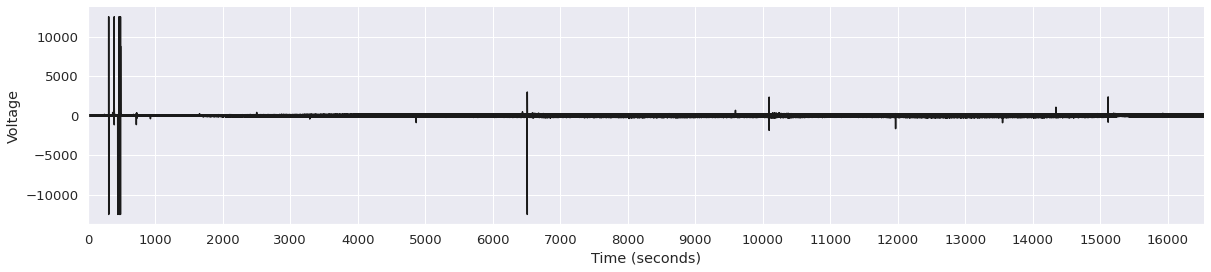

In [5]:
plot_nice(raw_data)

In [142]:
df.head()

,start_time,end_time,AUC,peak_amplitude,peak_freq
0,10532,10592,1983.2569,179.44909,38.747116
1,10532,10542,1990.5267,213.91618,41.270185
2,10532,10832,1863.9016,170.91608,38.910035


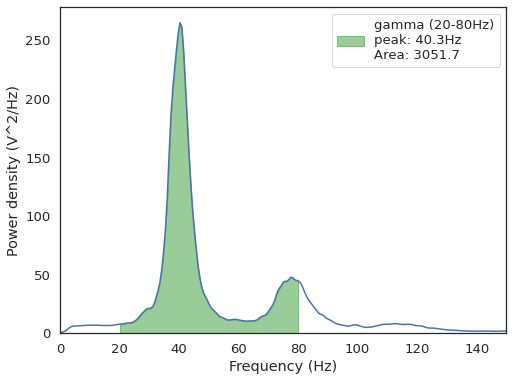

Area under the curve in gamma: 3051.65,  max frequency 40.28Hz


In [177]:
# Trying to replicate spike2 fft power
fs = 5000
data = raw_data[10532*fs:10832*fs]
freqs, res_fft = welch(data, fs=fs, window='hann', nperseg=8192/2, \
                       nfft = 8192, scaling = 'density', average='mean')
res_fft = res_fft
sns.set(font_scale=1.2, style='white')
idx_delta = np.logical_and(freqs >= 20, freqs <= 80)
plt.figure(figsize=(8,6))
plt.plot(freqs, res_fft)
plt.xlim(0,150)
idx = (freqs >=20.) & (freqs<=80)
x = freqs[idx]
y = res_fft[idx]
plt.fill_between(freqs, res_fft, where=idx_delta, color='green', alpha=.4, label = 
                 f'gamma (20-80Hz)\npeak: {x[np.where(y == y.max())][0]:.1f}Hz\nArea: {np.trapz(x=x, y=y):.1f}')
plt.xlabel('Frequency (Hz)')
plt.ylim(0, )
plt.ylabel('Power density (V^2/Hz)')
plt.legend()
plt.savefig('example_3_from_hugh.jpg')
plt.show()

print(f'Area under the curve in gamma: {np.trapz(x=x, y = y):.2f},  max frequency {x[np.where(y == y.max())][0]:.2f}Hz')